<a href="https://colab.research.google.com/github/Angus-Eastell/Intro_to_AI/blob/main/4_4_nn_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN exercises

This notebook basically asks you to re-do stuff in the previous two notebooks.  You should:
* Read the original notebooks.
* Try the exercises here without looking at the original notebooks.
* When you get stuck (everyone gets stuck), try to solve the problem yourself:
  - If you can't remember a function, search for it!
  - If you got an error messages.  What does it mean?  Search for the error message in Google.  Ask [ChatGPT](https://chat.openai.com/) (though ChatGPT can be wrong...).
* For many of the answers, I refer back to the original notebooks.

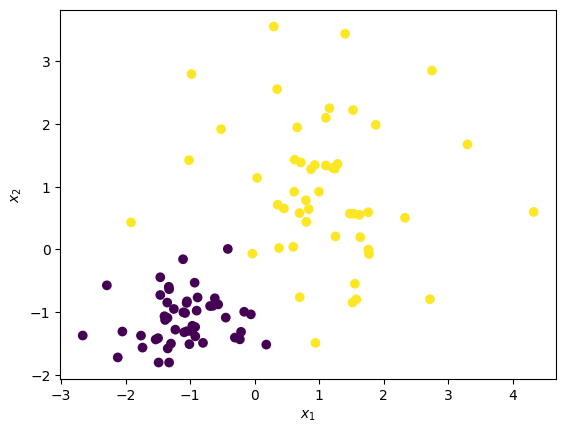

In [2]:
import torch as t
import matplotlib.pyplot as plt
t.manual_seed(1) #Fix the random seed, so we always generate the same data.

N = 100
x_class_0 = 0.5*t.randn(N//2, 2) - 1
x_class_1 = t.randn(N//2, 2) + 1
X = t.cat([x_class_0, x_class_1], 0)
y = t.cat([t.zeros(N//2, 1), t.ones(N//2, 1)], 0)

plt.scatter(x=X[:, 0], y=X[:, 1], c=y)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

def loss(l):
    return -(y*t.nn.functional.logsigmoid(l) + (1-y)*t.nn.functional.logsigmoid(-l)).sum()

def plot_decision_boundary(net, X, Y):
    #Non-examinable; just for demonstration purposes.
    x0_grid, x1_grid = t.meshgrid(t.linspace(-4, 4, 1000),
                                  t.linspace(-4, 4, 1000),
                                  indexing="ij")

    X_grid = t.stack([x0_grid, x1_grid], dim=-1)
    c_grid = (0<net(X_grid))[..., 0].detach()

    plt.contour(x0_grid, x1_grid, c_grid, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y)

    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

#### Part 1

Define and train a neural network, defining parameters as in Notebook 4.1:
```
bias0 = t.randn(hidden_features, requires_grad=True)
```
At the end, use `plot_decision_boundary(net, X, Y)` to plot your network's predictions.  (Note that for this function to work, you need to be able to apply your network to data using `net(X)`).

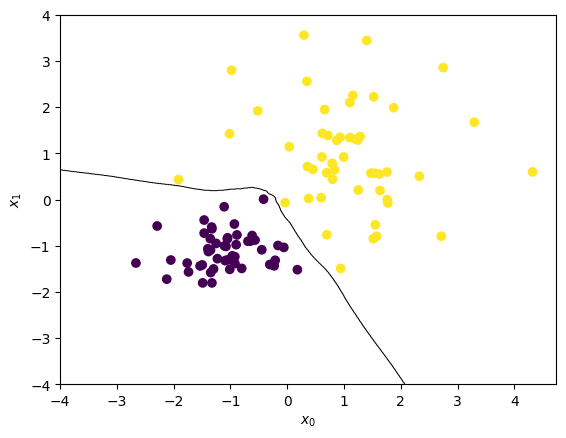

In [13]:
# Your code here

input_features = 2
output_features = 1
hidden_features = 500

# establish bias and weights
# requires_grad allows py.torch to keep track of the gradients
bias0 = t.randn(hidden_features, requires_grad = True)
weights0 = t.randn(input_features, hidden_features, requires_grad = True)

bias1 = t.randn(output_features, requires_grad = True)
weights1 = t.randn(hidden_features, output_features, requires_grad = True)

# apply relu and find weights for output
def net(input):
  output_layer0 = t.relu(input @ weights0 + bias0)
  output_layer1 = output_layer0 @ weights1 + bias1
  return output_layer1

# finding loss for gradient descent
def loss(l):
    return -(y*t.nn.functional.logsigmoid(l) + (1-y)*t.nn.functional.logsigmoid(-l)).sum()

# applying gradient descent

learning_rate = 0.001
for i in range(200):

  # calculating the loss
  L = loss(net(X))
  # finding the gradients
  L.backward()

  # calculates the gradient descent
  # .data.add alters the data by this
  bias0.data.add_( -learning_rate*bias0.grad)
  weights0.data.add_( -learning_rate*weights0.grad)
  bias1.data.add_( -learning_rate*bias1.grad)
  weights1.data.add_( -learning_rate*weights1.grad)

  # resets the gradient to 0 for next calculation
  bias0.grad.zero_()
  weights0.grad.zero_()
  bias1.grad.zero_()
  weights1.grad.zero_()

# plotting descision boundary
plot_decision_boundary(net, X, y)





#### Part 2

Define `MyReLU` and `MyLinear` classes.  Use the standard `MySequential class`.

Train the network, and use `plot_decision_boundary(net, X, Y)` to plot the predictions.

In [ ]:
class MySequential():
    def __init__(self, modules):
        """
        Takes a list of modules ("module" is PyTorch's general term for things
        like linear layers and ReLUs)
        """
        self.modules = modules

    def __call__(self, x):
        """
        Applies each module in sequence.  If we have two modules
        self.modules[1](self.modules[0](x))
        """
        for mod in self.modules:
            x = mod(x)
        return x

    def parameters(self):
        """
        Lists all the parameters in all the modules.
        """
        full_list = []
        for mod in self.modules:
            for param in mod.parameters():
                full_list.append(param)
        return full_list


In [ ]:
# Your code here
class MyLinear():

  def __init__(self, in_features, out_features):

    # when class initialised weights and bias found
    # in_features can be inital_features or hidden_features
    # output_features can be hidden_features or output_features
    self.bias = t.randn(out_features, requires_grad = True)
    self.weights = t.randn(in_features, out_features, requires_grad = True)

  def __call__(self, x):

    # linear calculation

    return x @ self.weights + self.bias


class MyRelu():

  def __call__(self, x):

    # applies the relu function on x
    return t.relu(x)

input_features = 2
hidden_features = 500
output_features = 1

net = MySequential([
    MyLinear(input_features, hidden_features),
    MyRelu(),
    MyLinear(hidden_features, output_features)
    ])






#### Part 3

Define a neural network using the standard `torch.nn` classes.  Specifically:
* `nn.ReLU`
* `nn.Linear`
* `nn.Sequential`

Train the network, and use `plot_decision_boundary(net, X, Y)` to plot the predictions.

In [ ]:
# Your code here

#### Part 4

Define a neural network using `nn.ReLU` and `nn.Linear`, but _without_ `nn.Sequential`.  Instead, define your own network `MyNet` as a subclass of `nn.Module`.  This gives you more flexibility in how you run the network.  For instance, within `forward`, print the shape of the intermediate layer activations.

Train the network, and use `plot_decision_boundary(net, X, Y)` to plot the predictions.

In [ ]:
# Your code here